## Import Libraries

In [44]:
import pandas as pd

import dash
from dash import Dash, dash_table
import dash_html_components as html
import dash_core_components as dcc
from dash.dependencies import Output, Input, State

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import numpy as np
from datetime import date, timedelta
import datetime

from sklearn.preprocessing import StandardScaler, MinMaxScaler

### Read the data

In [45]:
df = pd.read_excel("C:/Users/PanSt/OneDrive/Υπολογιστής/Poker League 2023.xlsx")
df.head()

c:\Users\PanSt\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning:

Unknown extension is not supported and will be removed

c:\Users\PanSt\anaconda3\lib\site-packages\openpyxl\worksheet\_read_only.py:79: UserWarning:

Conditional Formatting extension is not supported and will be removed



,Unnamed: 0,NET,PPG,TABLES,2023-01-14 00:00:00,2023-01-21 00:00:00,2023-01-28 00:00:00,2023-02-10 00:00:00,2023-02-19 00:00:00,2023-03-12 00:00:00,...,2023-08-04 00:00:00,2023-08-12 00:00:00,2023-08-17 00:00:00,2023-08-19 00:00:00,2023-08-20 00:00:00,2023-09-03 00:00:00,2023-09-24 00:00:00,2023-10-01 00:00:00,2023-10-15 00:00:00,2023-10-22 00:00:00
0,Ashish,146.75,5.644231,26,-5.00,24.60,-24.00,28.7,-20.0,25.05,...,11.20,68.15,10.1,-30.0,-75.75,26.35,6.05,78.85,21.50,51.95
1,Sid,116.00,4.833333,24,-15.00,-10.00,-16.00,-20.0,-10.0,-3.40,...,-20.00,-20.00,NaN,9.9,21.95,57.15,NaN,63.10,34.85,-40.00
2,Chris,127.70,5.320833,24,37.35,1.15,13.35,7.8,-38.0,-30.00,...,NaN,27.00,13.0,28.1,60.60,-31.50,-29.75,-40.00,NaN,45.70
3,Panos,69.45,2.893750,24,-0.95,2.60,-3.45,-10.2,7.3,15.25,...,-21.95,-26.95,-7.2,28.0,-35.20,NaN,-5.15,29.45,38.20,23.70
4,Kartik,134.85,7.932353,17,-5.00,NaN,12.70,9.7,17.8,11.20,...,71.75,-20.00,NaN,-20.0,33.85,-20.00,28.85,48.10,NaN,-20.00


In [46]:
df.set_index('Unnamed: 0', inplace=True)
df.rename_axis(None, inplace=True) #remove index header

In [47]:
df.head()

,NET,PPG,TABLES,2023-01-14 00:00:00,2023-01-21 00:00:00,2023-01-28 00:00:00,2023-02-10 00:00:00,2023-02-19 00:00:00,2023-03-12 00:00:00,2023-04-02 00:00:00,...,2023-08-04 00:00:00,2023-08-12 00:00:00,2023-08-17 00:00:00,2023-08-19 00:00:00,2023-08-20 00:00:00,2023-09-03 00:00:00,2023-09-24 00:00:00,2023-10-01 00:00:00,2023-10-15 00:00:00,2023-10-22 00:00:00
Ashish,146.75,5.644231,26,-5.00,24.60,-24.00,28.7,-20.0,25.05,-0.55,...,11.20,68.15,10.1,-30.0,-75.75,26.35,6.05,78.85,21.50,51.95
Sid,116.00,4.833333,24,-15.00,-10.00,-16.00,-20.0,-10.0,-3.40,-14.65,...,-20.00,-20.00,NaN,9.9,21.95,57.15,NaN,63.10,34.85,-40.00
Chris,127.70,5.320833,24,37.35,1.15,13.35,7.8,-38.0,-30.00,6.00,...,NaN,27.00,13.0,28.1,60.60,-31.50,-29.75,-40.00,NaN,45.70
Panos,69.45,2.893750,24,-0.95,2.60,-3.45,-10.2,7.3,15.25,3.05,...,-21.95,-26.95,-7.2,28.0,-35.20,NaN,-5.15,29.45,38.20,23.70
Kartik,134.85,7.932353,17,-5.00,NaN,12.70,9.7,17.8,11.20,NaN,...,71.75,-20.00,NaN,-20.0,33.85,-20.00,28.85,48.10,NaN,-20.00


# Profit/Loss against time analysis

In [48]:
dftime2 = df.iloc[:,2:].T.copy() # tp be used for personal form calculation
dftime3 = df.iloc[:,2:].T.copy() # tp be used for global form calculation
df.fillna(0, inplace=True)
dftime = df.iloc[:,2:].T.copy()

In [49]:
dftime['Guests'] = dftime.T[dftime.T['TABLES'] < 10].sum().to_frame() #sum all guest values for by date
dftime = dftime[['Ashish','Sid','Chris','Panos','Kartik','Tanish','Guests']] #create the new table
dftime.drop(index='TABLES' , inplace= True)
dftime = dftime.rename_axis('Date').reset_index()
#dftime['Date'] = dftime['Date'].dt.strftime('%d-%m')

# Initialize variables to keep track of cumulative sums for each column
cumulative_sums = {col: 0 for col in dftime.columns[1:]}

# Iterate through the columns and update values
for col in dftime.columns[1:]:
    for index, row in dftime.iterrows():
        cumulative_sums[col] += row[col]
        dftime.at[index, col] = cumulative_sums[col]

dftime.head()

,Date,Ashish,Sid,Chris,Panos,Kartik,Tanish,Guests
0,2023-01-14,-5.0,-15.0,37.35,-0.95,-5.0,-10.0,-1.40
1,2023-01-21,19.6,-25.0,38.50,1.65,-5.0,-10.0,-19.75
2,2023-01-28,-4.4,-41.0,51.85,-1.80,7.7,-15.0,2.65
3,2023-02-10,24.3,-61.0,59.65,-12.00,17.4,-15.0,-13.35
4,2023-02-19,4.3,-71.0,21.65,-4.70,35.2,34.2,-19.65


In [50]:
dftime['Date'] = dftime['Date'].dt.strftime('%d-%b') #change the date format
dftime_melt = dftime.melt(id_vars='Date', value_vars=list(dftime.columns[1:])).rename({'variable':'Player','value':'Net Profit/Loss'}, axis='columns') #melt the table and rename the new columns
dftime_melt['Net Profit/Loss'] = round(dftime_melt['Net Profit/Loss'],2) # round all values to 2 decimal points
dftime_melt

,Date,Player,Net Profit/Loss
0,14-Jan,Ashish,-5.00
1,21-Jan,Ashish,19.60
2,28-Jan,Ashish,-4.40
3,10-Feb,Ashish,24.30
4,19-Feb,Ashish,4.30
...,...,...,...
177,03-Sep,Guests,-173.85
178,24-Sep,Guests,-173.85
179,01-Oct,Guests,-313.35
180,15-Oct,Guests,-395.25


## Group Analysis

In [51]:
fig = px.bar(dftime_melt,  
            x='Player', y = "Net Profit/Loss", animation_frame="Date", range_y=(-500,200),hover_data=['Net Profit/Loss'],color='Net Profit/Loss', width=1800, height=800, range_color=(-500,200))
fig.update_layout(
    title="Time Lapse of Profit/Loss of every player",
    xaxis_title="Date",
    yaxis_title="Net Profit/Loss")

fig.update_traces(textfont_size=12, textangle=0, textposition="outside",overwrite=True, )  
fig.layout.updatemenus[0].buttons[0].args[1]["frame"]["duration"] = 600
fig.show()

## Player Analysis

In [52]:
person = 'Chris'

### Histogtam of performance

In [ ]:
dftime

In [53]:
namelist = dftime.columns[1:-1].to_list()

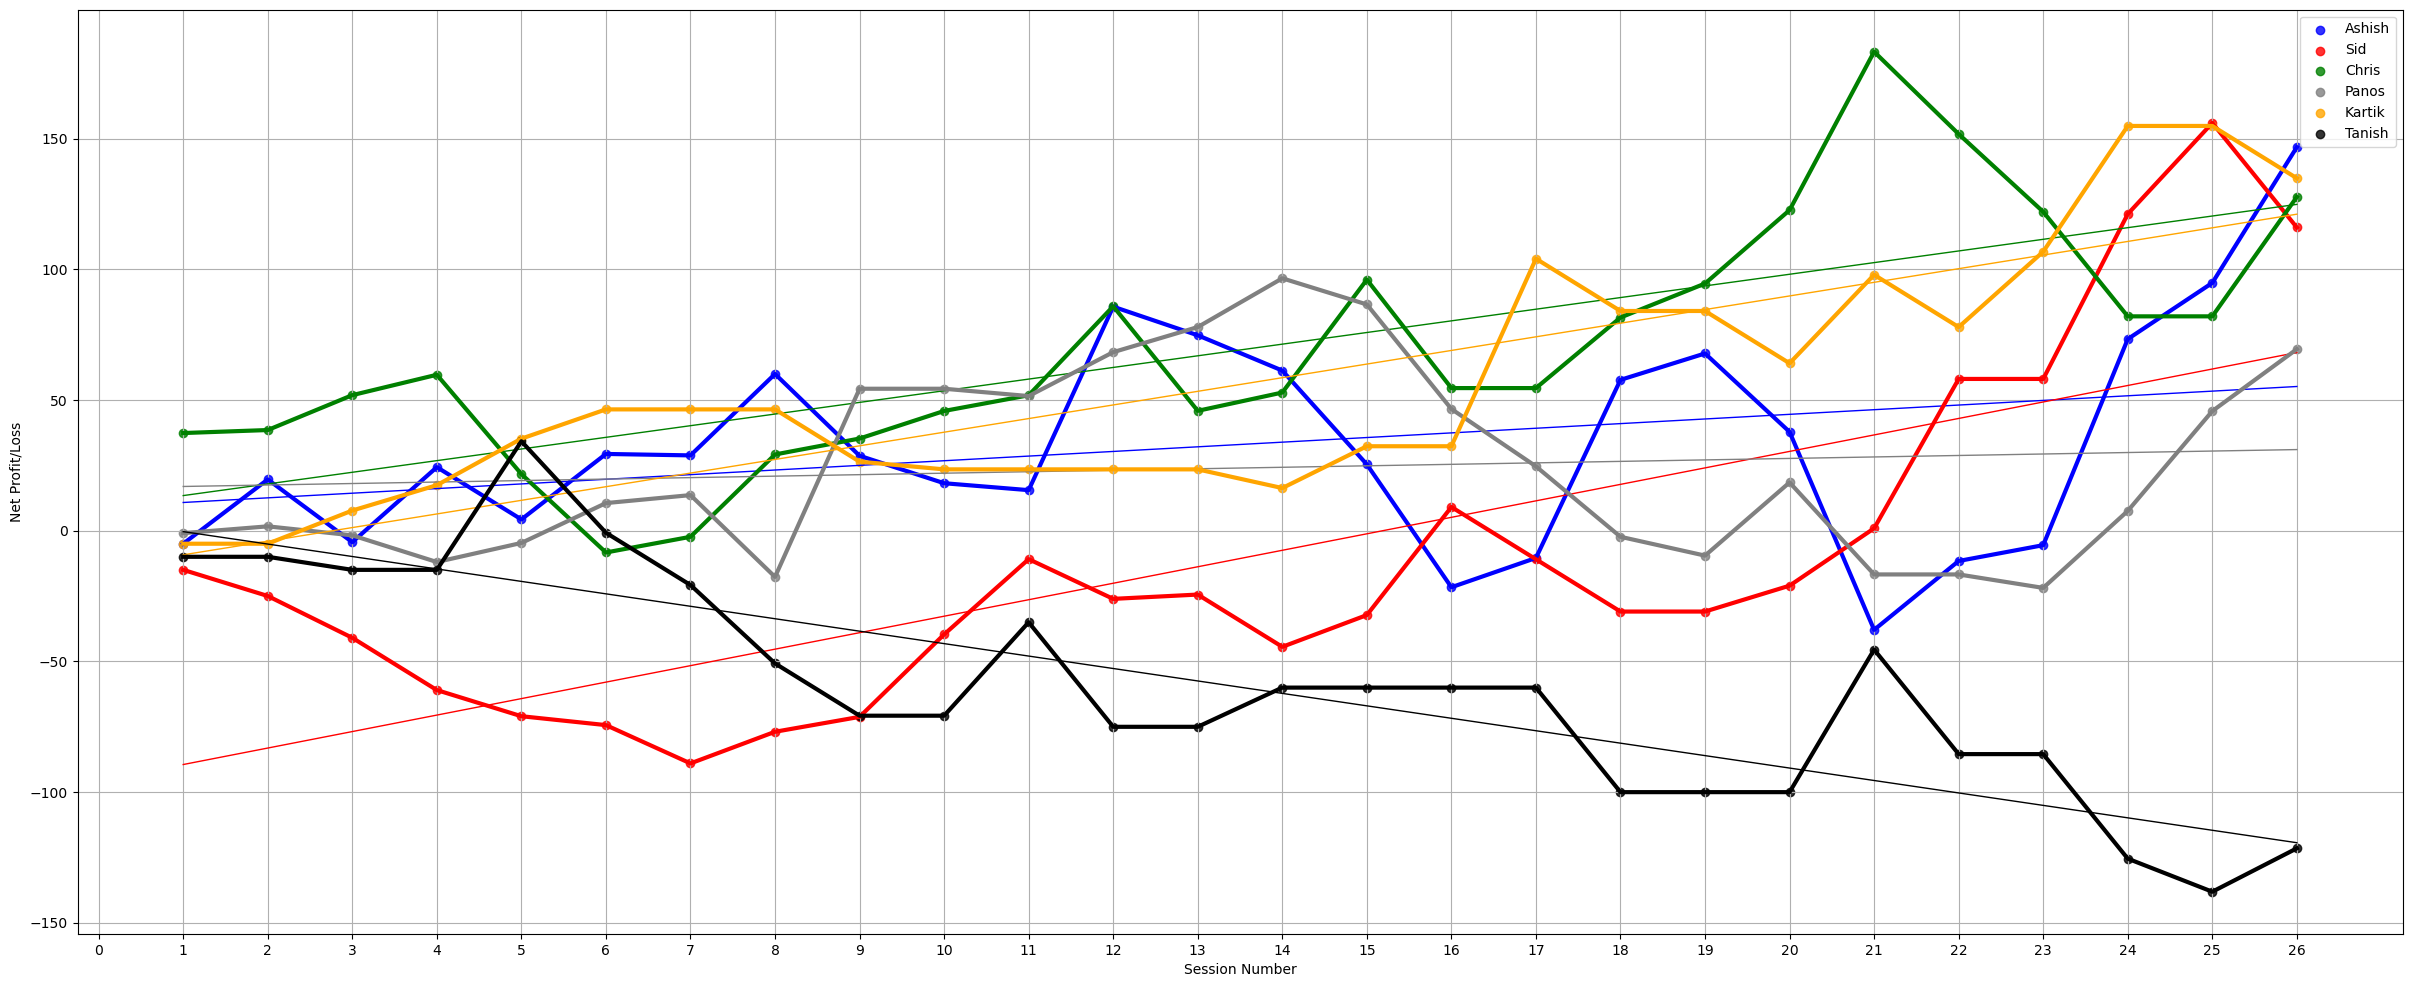

In [54]:
plt.figure(figsize=(30,12))
colorlist = ["blue", "red", "green", "grey", "orange", "black"]

for index, name in enumerate(namelist):
    sns.regplot(x=np.arange(1,len(dftime[name])+1,1),y=name, ci=None, data=dftime, color='r', scatter_kws={'color':colorlist[index]}, line_kws={'color':colorlist[index], 'linewidth':1}, label=name)
    plt.plot(np.arange(1,len(dftime[name])+1,1),dftime[name], color=colorlist[index], linewidth=3)

plt.legend()
plt.ylabel('Net Profit/Loss')
plt.xlabel('Session Number')
plt.xticks(np.arange(0,len(dftime['Panos'])+1))
plt.grid()
plt.show()

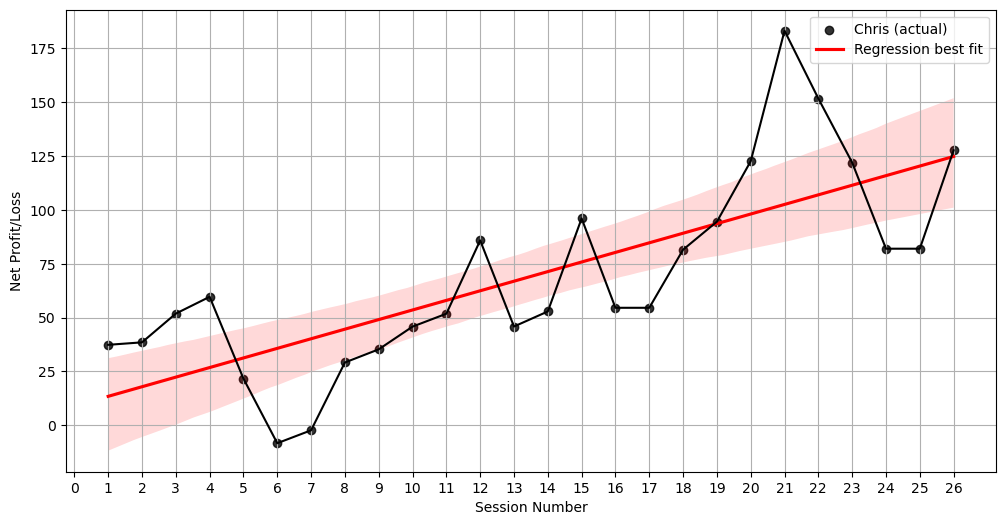

In [55]:
plt.figure(figsize=(12,6))
sns.regplot(x=np.arange(1,len(dftime[person])+1,1),y=person, data=dftime, color='r', scatter_kws={'color':'black'}, line_kws={'color':'red'})
plt.plot(np.arange(1,len(dftime[person])+1,1),dftime[person],color='black')
plt.legend([person+' (actual)','Regression best fit'])
plt.ylabel('Net Profit/Loss')
plt.xlabel('Session Number')
plt.xticks(np.arange(0,len(dftime[person])+1))
plt.grid()
plt.show()

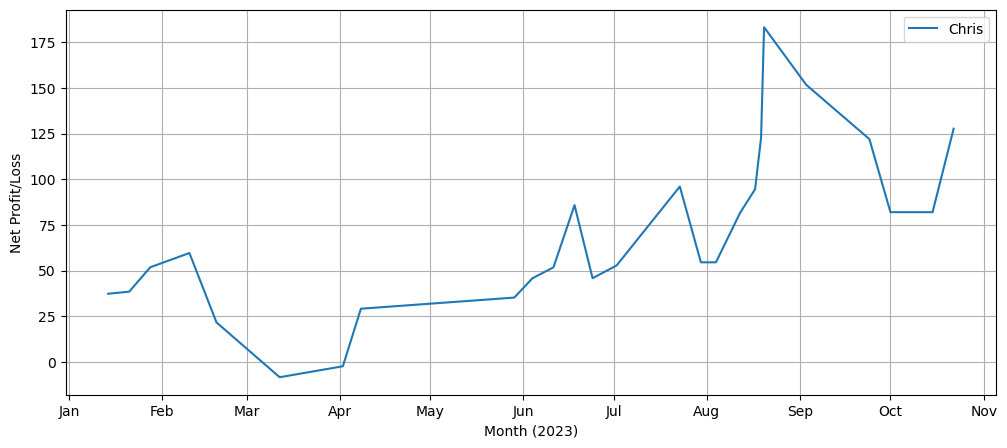

In [56]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(pd.to_datetime(dftime['Date'] + f"-{2023}", format='%d-%b-%Y'), dftime[person], label=person)
ax.set_ylabel('Net Profit/Loss')
ax.set_xlabel('Month (2023)')

#plt.xticks(rotation=45)  # Rotate x-axis labels for readability
ax.xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%b"))
#ax.set_xlim(datetime.date(2023, 1 ,1), datetime.date(2023, 10 ,31))
plt.legend()

plt.grid()
plt.show()

### Personal Form Calculator

In [57]:
dftime5 = dftime2[person].dropna()
dftime5.drop(index='TABLES' , inplace= True) 
dftime5 = pd.Series([sum(dftime5[i:i+3]) for i in range(0, len(dftime5)-2, 1)]) # sum 3 in a row together

In [58]:
x = np.array(dftime5).reshape(-1,1) #reshape to fit transform
filtered_data = StandardScaler().fit_transform(x) #normalise first 
filtered_data = MinMaxScaler().fit_transform(filtered_data)*10 #convert normalised data into min, max
filtered_data = [np.round(datum * 2) / 2 for datum in filtered_data]

In [59]:
"""fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = float(filtered_data[-1]),
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "{} Personal Form".format(person), 'font': {'size': 24}},
    delta = {'reference': int(filtered_data[-2]), 'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 5], 'color': 'red'},
            {'range': [5, 10], 'color': 'cyan'}],
        }))

fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

fig.show()"""

'fig = go.Figure(go.Indicator(\n    mode = "gauge+number+delta",\n    value = float(filtered_data[-1]),\n    domain = {\'x\': [0, 1], \'y\': [0, 1]},\n    title = {\'text\': "{} Personal Form".format(person), \'font\': {\'size\': 24}},\n    delta = {\'reference\': int(filtered_data[-2]), \'increasing\': {\'color\': "RebeccaPurple"}},\n    gauge = {\n        \'axis\': {\'range\': [None, 10], \'tickwidth\': 1, \'tickcolor\': "darkblue"},\n        \'bar\': {\'color\': "darkblue"},\n        \'bgcolor\': "white",\n        \'borderwidth\': 2,\n        \'bordercolor\': "gray",\n        \'steps\': [\n            {\'range\': [0, 5], \'color\': \'red\'},\n            {\'range\': [5, 10], \'color\': \'cyan\'}],\n        }))\n\nfig.update_layout(paper_bgcolor = "lavender", font = {\'color\': "darkblue", \'family\': "Arial"})\n\nfig.show()'

### Global Form Calculator

In [60]:
dftime3 = dftime3.iloc[:,0:6] #pick only the first 6 columns
if 'TABLES' in dftime3.index:  
    dftime3.drop(index='TABLES' , inplace= True) #drop row with the number of tables
person_column = dftime3.pop(person)
dftime3[person] = person_column
global_list = []
for column in dftime3:
    dftime4 = dftime3[column].dropna() #drop all NaN values
    global_list.extend(pd.Series([sum(dftime4[i:i+3]) for i in range(0, len(dftime4)-2, 1)])) # sum 3 in a row together

In [61]:
filtered_data2 = StandardScaler().fit_transform(np.array(global_list).reshape(-1, 1)) #normalise first 
filtered_data2 = MinMaxScaler().fit_transform(filtered_data2)*10 #convert normalised data into min, max
filtered_data2 = [np.round(datum * 2) / 2 for datum in filtered_data2]

In [62]:
"""fig = go.Figure(go.Indicator(
    mode = "gauge+number+delta",
    value = float(filtered_data[-1]),
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "{} Global Form".format(person), 'font': {'size': 24}},
    delta = {'reference': int(filtered_data[-2]), 'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 5], 'color': 'red'},
            {'range': [5, 10], 'color': 'cyan'}],
        }))

fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

fig.show()"""

'fig = go.Figure(go.Indicator(\n    mode = "gauge+number+delta",\n    value = float(filtered_data[-1]),\n    domain = {\'x\': [0, 1], \'y\': [0, 1]},\n    title = {\'text\': "{} Global Form".format(person), \'font\': {\'size\': 24}},\n    delta = {\'reference\': int(filtered_data[-2]), \'increasing\': {\'color\': "RebeccaPurple"}},\n    gauge = {\n        \'axis\': {\'range\': [None, 10], \'tickwidth\': 1, \'tickcolor\': "darkblue"},\n        \'bar\': {\'color\': "darkblue"},\n        \'bgcolor\': "white",\n        \'borderwidth\': 2,\n        \'bordercolor\': "gray",\n        \'steps\': [\n            {\'range\': [0, 5], \'color\': \'red\'},\n            {\'range\': [5, 10], \'color\': \'cyan\'}],\n        }))\n\nfig.update_layout(paper_bgcolor = "lavender", font = {\'color\': "darkblue", \'family\': "Arial"})\n\nfig.show()'

### Personal and Global Form Gauge charts

In [63]:
# Create a subplot grid with 1 row and 2 columns
fig = make_subplots(rows=1, cols=2)

# Define data for the first gauge chart
trace1 = (go.Indicator(
    mode = "gauge+number+delta",
    value = float(filtered_data[-1]),
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "{} Personal Form".format(person), 'font': {'size': 24}},
    delta = {'reference': int(filtered_data[-2]), 'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 5], 'color': 'red'},
            {'range': [5, 10], 'color': 'cyan'}],
        }))

# Define data for the second gauge chart
trace2 = (go.Indicator(
    mode = "gauge+number+delta",
    value = float(filtered_data2[-1]),
    domain = {'x': [0, 1], 'y': [0, 1]},
    title = {'text': "{} Global Form".format(person), 'font': {'size': 24}},
    delta = {'reference': int(filtered_data2[-2]), 'increasing': {'color': "RebeccaPurple"}},
    gauge = {
        'axis': {'range': [None, 10], 'tickwidth': 1, 'tickcolor': "darkblue"},
        'bar': {'color': "darkblue"},
        'bgcolor': "white",
        'borderwidth': 2,
        'bordercolor': "gray",
        'steps': [
            {'range': [0, 5], 'color': 'red'},
            {'range': [5, 10], 'color': 'cyan'}],
        }))

fig.update_layout(paper_bgcolor = "lavender", font = {'color': "darkblue", 'family': "Arial"})

fig = make_subplots(
    rows=1,
    cols=2,
    specs=[[{'type' : 'indicator'}, {'type' : 'indicator'}]],
    )

fig.append_trace(trace1, row=1, col=1)
fig.append_trace(trace2, row=1, col=2)

fig.show()

# Dash Board

In [64]:
app = dash.Dash(__name__)
app.config.suppress_callback_exceptions = True
# Define the layout of the dashboard
app.layout = html.Div([
    dcc.Tabs(id="tabs", value='personal', children=[
        dcc.Tab(label='Personal Data', value='personal'),
        dcc.Tab(label='Global Data', value='global'),
    ]),
    html.Div(id='page-content'),
])

# Callback to switch between subpages
@app.callback(Output('page-content', 'children'), Input('tabs', 'value'))
def render_content(tab):
    if tab == 'personal': #break into tabs
        return html.Div([
            html.H1('Personal Data Page'),
            dcc.Dropdown( #make a dropdown section for the person at interrest
                id='Player',
                options=[{'label': person, 'value': person} for person in namelist],
                value=namelist[1]  # Set the default value

            )
        ])
    elif tab == 'global':
        return html.Div([
            html.H1('Global Data Page'),
            # Add your global data visualizations here
        ])

if __name__ == '__main__':
    app.run_server(port=8050, threaded=False)

Dash is running on http://127.0.0.1:8050/

 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)


127.0.0.1 - - [25/Oct/2023 16:41:22] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2023 16:41:22] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2023 16:41:22] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2023 16:41:22] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [25/Oct/2023 16:41:22] "GET /_dash-component-suites/dash/dcc/async-dropdown.js HTTP/1.1" 200 -
